In [58]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score

In [3]:
nlp = spacy.load('en')

file_names = open('PoemList.txt', 'r')
file_names = file_names.readlines()
file_names = [file[:-1] for file in file_names]
author_poem = [file[:-4] for file in file_names]
poem_titles = [re.sub(r'.*_', '', article) for article in author_poem]
poets = [re.sub(r'_.*', '', article) for article in author_poem]

poems = []
word_count = []
line_count = []
num_of_sents = []
processed_poems = []
max_sent_length = []
min_sent_length = []
for text in file_names:
    opened = open(text, 'r').read()
    poem = opened.replace("\n"," ")
    poem = poem.replace('-', '')
    poems.append(poem)
    
    wordcount = Counter(poem.split())
    wordcount = sum(wordcount.values())
    word_count.append(wordcount)
    
    num_lines = sum(1 for line in open(text))
    line_count.append(num_lines)
    
    sentences = nlp(poem)
    processed_poems.append(sentences)
    
    sentences = [[sent] for sent in sentences.sents]
    num_of_sents.append(len(sentences))
    
    sentence_length = [len(sent[0]) for sent in sentences]
    max_sent_length.append(max(sentence_length))
    min_sent_length.append(min(sentence_length))
    
poems_df = pd.DataFrame()
poems_df['poem'] = poems
poems_df["poem_titles"] = poem_titles
poems_df['authors'] = poets
poems_df['word_count'] = word_count
poems_df['line_count'] = line_count
poems_df['num_of_sents'] = num_of_sents
poems_df['processed_poems'] = processed_poems
poems_df['max_sent_length'] = max_sent_length
poems_df['min_sent_length'] = min_sent_length

poems_df.head()

,poem,poem_titles,authors,word_count,line_count,num_of_sents,processed_poems,max_sent_length,min_sent_length
0,"Lying, thinking Last night How to find my soul...",Alone,Angelou,162,42,16,"(Lying, ,, thinking, Last, night, How, to, fin...",33,3
1,Curtains forcing their will against the win...,AwakingInNewYork,Angelou,38,11,2,"(Curtains, forcing, their, will, , against,...",37,20
2,A free bird leaps on the back of the wind ...,CagedBird,Angelou,193,43,6,"(A, free, bird, leaps, , on, the, back, of, t...",41,37
3,"The eye follows, the land Slips upward, creas...",CaliforniaProdigal,Angelou,130,35,11,"(The, eye, follows, ,, the, land, , Slips, up...",31,6
4,"One foot down, then hop! It's hot. Good things...",HarlemHopscotch,Angelou,90,17,14,"(One, foot, down, ,, then, hop, !, It, 's, hot...",18,4


In [4]:
poems_df = poems_df.sample(frac=1)
poems_df = poems_df.sample(frac=1)
poems_df = poems_df.sample(frac=1)
poems_df = poems_df.sample(frac=1)
poems_df = poems_df.sample(frac=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10dbb8080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10db47780>]], dtype=object)

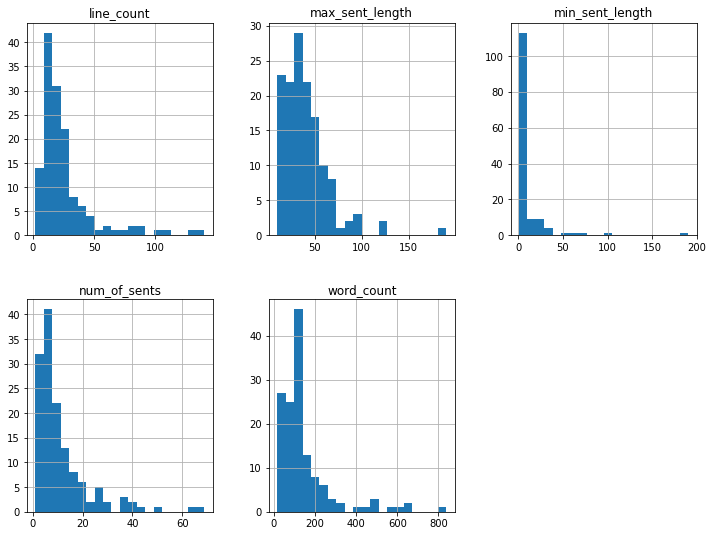

In [5]:
poems_df.hist(bins=20, figsize=(12,9), layout=(2,3))

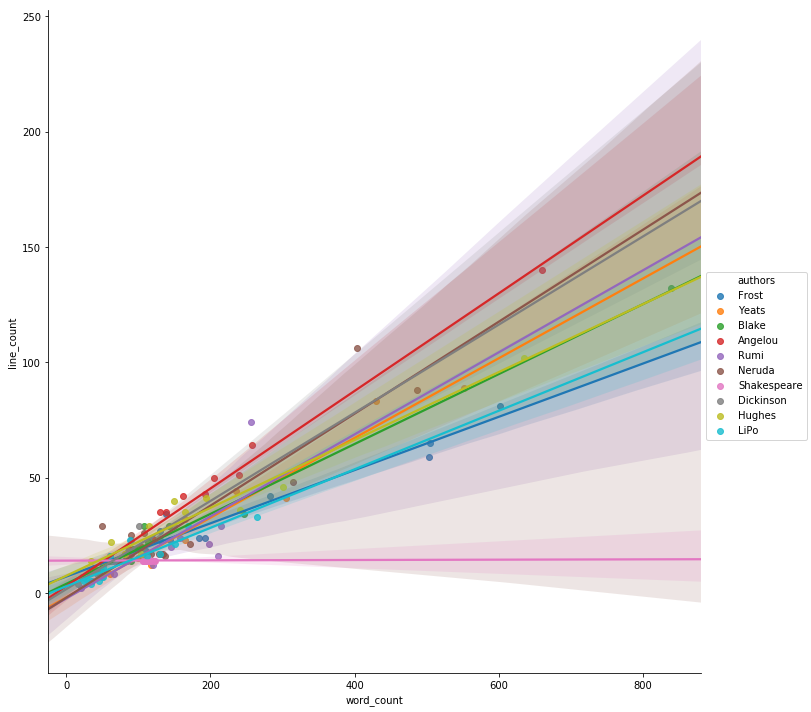

In [6]:
sns.lmplot(x="word_count", y="line_count", hue="authors", size=10, data=poems_df)
plt.show()

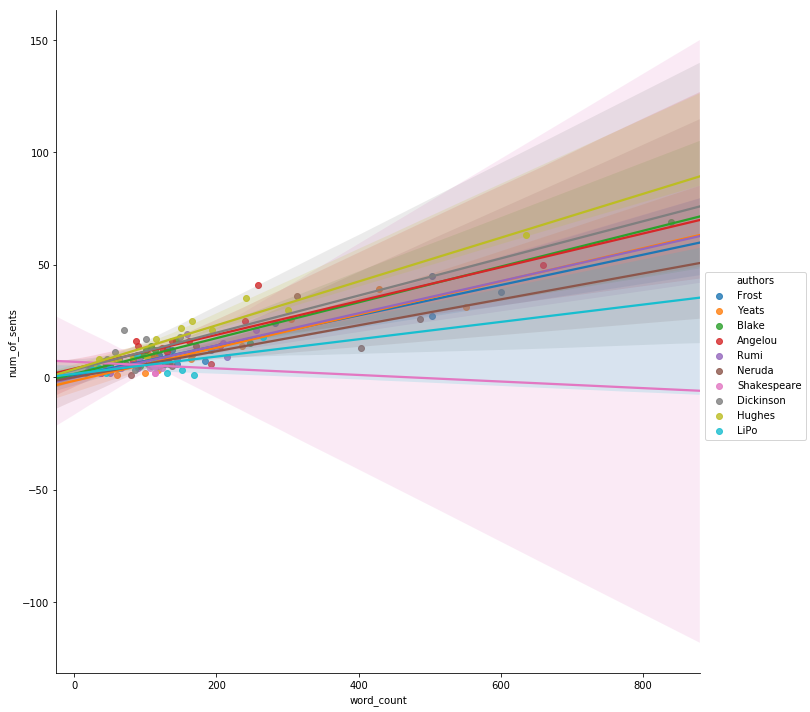

In [7]:
sns.lmplot(x="word_count", y="num_of_sents", hue="authors", size = 10, data=poems_df)
plt.show()

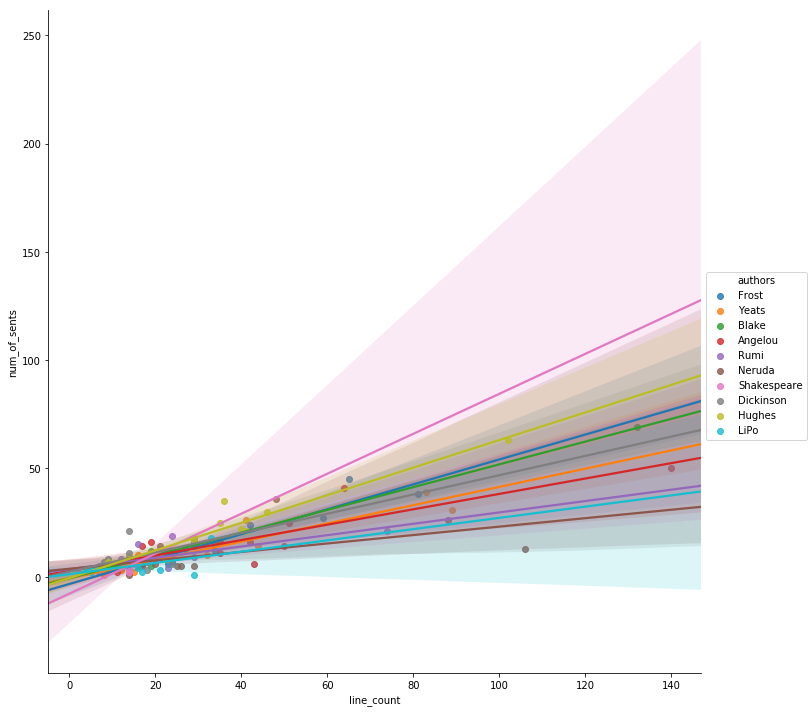

In [8]:
sns.lmplot(x="line_count", y="num_of_sents", hue="authors", size= 10, data=poems_df)
plt.show()

### Do cluster with original non-pca'd features... also use the percentage of variance retained function to see how much variance was kept using pca...

In [9]:
poems_df.columns

Index(['poem', 'poem_titles', 'authors', 'word_count', 'line_count',
       'num_of_sents', 'processed_poems', 'max_sent_length',
       'min_sent_length'],
      dtype='object')

                 word_count  line_count  num_of_sents  max_sent_length  \
word_count         1.000000    0.930038      0.872282         0.298430   
line_count         0.930038    1.000000      0.851595         0.232049   
num_of_sents       0.872282    0.851595      1.000000        -0.012110   
max_sent_length    0.298430    0.232049     -0.012110         1.000000   
min_sent_length   -0.097837   -0.123069     -0.275801         0.629018   

                 min_sent_length  
word_count             -0.097837  
line_count             -0.123069  
num_of_sents           -0.275801  
max_sent_length         0.629018  
min_sent_length         1.000000  


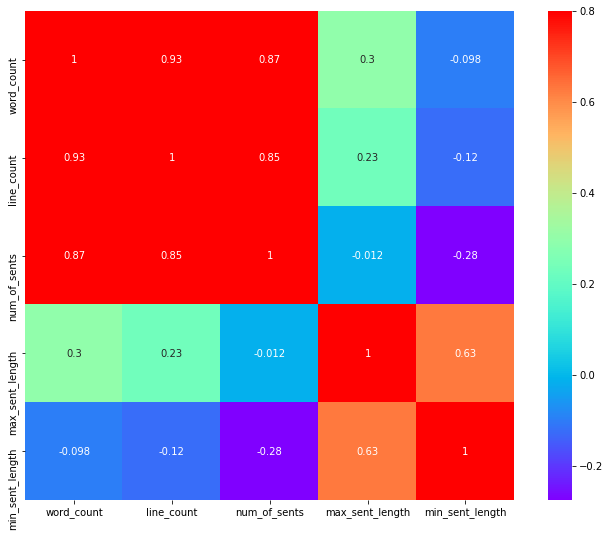

In [10]:
X = poems_df.drop(['poem_titles', 'authors','poem','processed_poems'], axis = 1)

# Make the correlation matrix.
corrmat = X.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap = 'rainbow')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


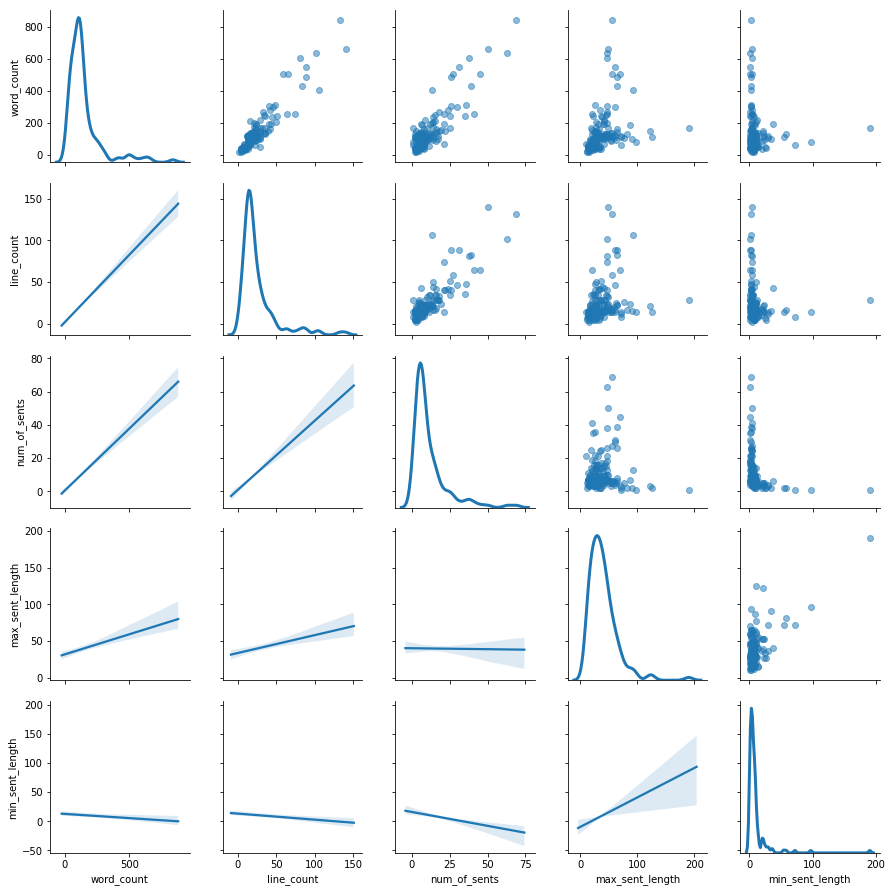

In [11]:
# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(X.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

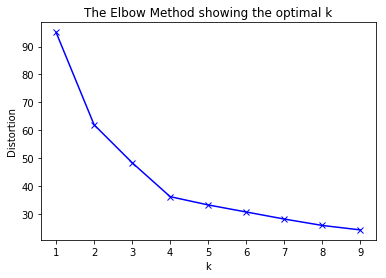

In [12]:
# clustering dataset
# determine k using elbow method
 
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
 
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [13]:
X = poems_df.drop(['poem_titles', 'authors','poem','processed_poems'], axis = 1)

X_norm = normalize(X)

# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_norm)

In [14]:
X = poems_df.drop(['poem_titles', 'authors','poem','processed_poems'], axis = 1)

X_norm = normalize(X)

pca = PCA(n_components = None)
# Reduce it to two components.
X_pca = pca.fit_transform(X_norm)

explained_variance = pca.explained_variance_ratio_

explained_variance

array([ 0.75759501,  0.1399139 ,  0.07042541,  0.01974497,  0.0123207 ])

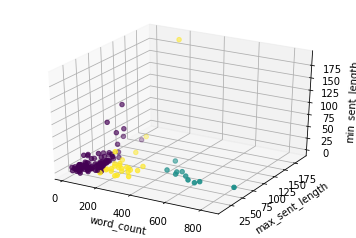

In [17]:
X = poems_df[['word_count', 'max_sent_length','min_sent_length']]

# # Normalize the data.
# X_norm = normalize(X)


# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X['word_count'], X['max_sent_length'], X['min_sent_length'], c=y_pred)

ax.set_xlabel('word_count')
ax.set_ylabel('max_sent_length')
ax.set_zlabel('min_sent_length')

plt.show()

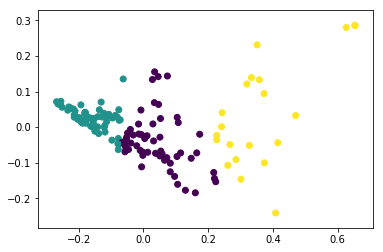

In [18]:
X = poems_df.drop(['poem_titles', 'authors','poem','processed_poems'], axis = 1)

# Normalize the data.
X_norm = normalize(X)

pca = PCA(n_components = 3)

# Reduce it to two components.
X_pca = pca.fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

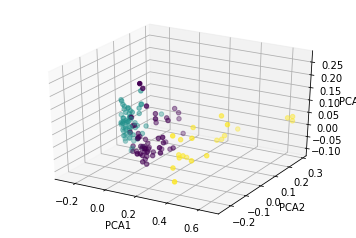

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:,2], c=y_pred)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

plt.show()

In [20]:
cluster_df = poems_df.copy()
cluster_df['cluster'] = y_pred

In [21]:
for i in range(cluster_df['cluster'].nunique()):
    cluster = cluster_df[cluster_df['cluster']== i]
    print('Cluster ', i, '\n', Counter(list(cluster['authors'])),'\n')

Cluster  0 
 Counter({'Shakespeare': 12, 'Neruda': 9, 'Dickinson': 7, 'Frost': 6, 'Blake': 6, 'LiPo': 5, 'Yeats': 5, 'Hughes': 4, 'Rumi': 2, 'Angelou': 1}) 

Cluster  1 
 Counter({'Angelou': 12, 'Hughes': 10, 'Frost': 8, 'Rumi': 8, 'Blake': 7, 'Yeats': 6, 'Dickinson': 5, 'Neruda': 4, 'LiPo': 2}) 

Cluster  2 
 Counter({'LiPo': 7, 'Rumi': 4, 'Yeats': 3, 'Shakespeare': 2, 'Dickinson': 2, 'Neruda': 1, 'Angelou': 1, 'Blake': 1}) 



In [22]:
cluster0 = cluster_df[cluster_df['cluster']==0]
print(Counter(list(cluster0['authors'])))
# print(set(list(cluster0['authors'])))

Counter({'Shakespeare': 12, 'Neruda': 9, 'Dickinson': 7, 'Frost': 6, 'Blake': 6, 'LiPo': 5, 'Yeats': 5, 'Hughes': 4, 'Rumi': 2, 'Angelou': 1})


In [23]:
cluster0.describe()

,word_count,line_count,num_of_sents,max_sent_length,min_sent_length,cluster
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.0
mean,93.859649,16.052632,6.315789,38.982456,7.912281,0.0
std,36.466442,5.720955,2.443343,16.614851,6.231489,0.0
min,22.000000,5.000000,3.000000,11.000000,1.000000,0.0
25%,61.000000,14.000000,5.000000,28.000000,3.000000,0.0
50%,106.000000,14.000000,6.000000,37.000000,8.000000,0.0
75%,118.000000,17.000000,7.000000,50.000000,10.000000,0.0
max,184.000000,29.000000,17.000000,87.000000,30.000000,0.0


In [24]:
cluster1 = cluster_df[cluster_df['cluster']==1]
print(Counter(list(cluster1['authors'])))

Counter({'Angelou': 12, 'Hughes': 10, 'Frost': 8, 'Rumi': 8, 'Blake': 7, 'Yeats': 6, 'Dickinson': 5, 'Neruda': 4, 'LiPo': 2})


In [25]:
cluster1.describe()

,word_count,line_count,num_of_sents,max_sent_length,min_sent_length,cluster
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.0
mean,220.870968,39.500000,19.306452,33.758065,4.693548,1.0
std,172.279461,29.271902,13.479296,16.681869,4.930962,0.0
min,42.000000,8.000000,6.000000,10.000000,1.000000,1.0
25%,106.250000,19.250000,10.000000,21.250000,2.000000,1.0
50%,163.500000,30.500000,14.500000,30.500000,4.000000,1.0
75%,257.500000,45.500000,24.750000,45.750000,5.000000,1.0
max,839.000000,140.000000,69.000000,93.000000,37.000000,1.0


In [26]:
cluster2 = cluster_df[cluster_df['cluster']==2]
print(Counter(list(cluster2['authors'])))

Counter({'LiPo': 7, 'Rumi': 4, 'Yeats': 3, 'Shakespeare': 2, 'Dickinson': 2, 'Neruda': 1, 'Angelou': 1, 'Blake': 1})


In [27]:
cluster2.describe()

,word_count,line_count,num_of_sents,max_sent_length,min_sent_length,cluster
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.0
mean,72.095238,10.857143,2.333333,60.000000,34.476190,2.0
std,45.968364,6.717780,0.795822,45.837757,43.253461,0.0
min,16.000000,2.000000,1.000000,12.000000,4.000000,2.0
25%,35.000000,5.000000,2.000000,25.000000,8.000000,2.0
50%,60.000000,9.000000,2.000000,41.000000,20.000000,2.0
75%,113.000000,14.000000,3.000000,82.000000,35.000000,2.0
max,169.000000,29.000000,4.000000,190.000000,190.000000,2.0


### Make sure to do a confusion matrix!!! Experiment with different clusters. Elbow graph!

In [28]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 5


### Take a look at 8 clusters... 

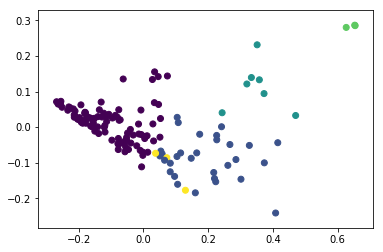

In [29]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.show()

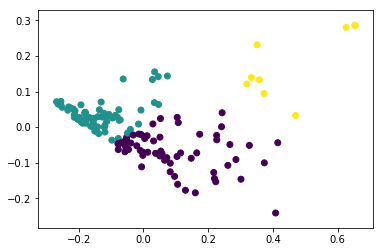

In [30]:
# We know we're looking for three clusters.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_pca)

#Predicted clusters.
predict=sc.fit_predict(X_pca)

#Graph results.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict)
plt.show()

In [31]:
cluster_df3 = poems_df.copy()
cluster_df3['clusters'] = predict

In [32]:
cluster_df3.head()

,poem,poem_titles,authors,word_count,line_count,num_of_sents,processed_poems,max_sent_length,min_sent_length,clusters
52,Having a wheel and four legs of its own Has ne...,TheGrindstone,Frost,601,81,38,"(Having, a, wheel, and, four, legs, of, its, o...",46,5,1
133,A sudden blow: the great wings beating still A...,LedaAndTheSwan,Yeats,113,17,9,"(A, sudden, blow, :, the, great, wings, beatin...",39,2,0
17,To see a World in a Grain of Sand And a Heave...,AuguriesOfInnocence,Blake,839,132,69,"(To, see, a, World, in, a, Grain, of, Sand, ,...",55,2,1
48,"Some say the world will end in fire, Some say ...",FireAndIce,Frost,51,9,4,"(Some, say, the, world, will, end, in, fire, ,...",15,14,1
53,"It was too lonely for her there, And too wild,...",TheHillWife,Frost,138,34,12,"(It, was, too, lonely, for, her, there, ,, And...",26,5,1


In [33]:
cluster3 = cluster_df[cluster_df['cluster']==0]

In [34]:
cluster3 = cluster_df[cluster_df['cluster']==1]

In [35]:
cluster3 = cluster_df[cluster_df['cluster']==2]

### Here is the bag of words analysis starts...

In [37]:
test = []
for i, poem in enumerate(poems_df['processed_poems']):
    poem_sents = [[sent, poems_df.loc[i,'authors']] for sent in poems_df.loc[i,'processed_poems'].sents]
    test.extend(poem_sents)

sentences_df = pd.DataFrame(test)
sentences_df.head()

,0,1
0,"(Lying, ,, thinking, Last, night, How, to, fin...",Angelou
1,"(And, bread, loaf, is, not, stone)",Angelou
2,"(I, came, up, with, one, thing)",Angelou
3,"(And, I, do, n’t, believe, I, ’m, wrong)",Angelou
4,"(That, nobody, ,)",Angelou


### First I will use the bag of words analysis on a poem level. As you can see, the results were not that great with the test sets. With only 140 poems available, I am pretty certain it is because there are not very many samples for the models to work with.

In [38]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    return allwords

In [43]:
set_bag = []

for i, poem in enumerate(poems_df['processed_poems']):
    allwords = bag_of_words(poem)
    set_bag.extend(allwords)
set_bag = set(set_bag)

In [39]:
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['processed_poems'] = sentences['processed_poems']
    df['authors'] = sentences['authors']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['processed_poems']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [45]:
bow_df = bow_features(poems_df, set_bag)

Processing row 0


In [46]:
bow_df.shape

(140, 3251)

In [47]:
Y = bow_df['authors']
X = np.array(bow_df.drop(['processed_poems','authors'], 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [48]:
rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train, Y_train)

print('Training set score:', rfc.score(X_train, Y_train))
print('Training set score:', rfc.score(X_test, Y_test))

Training set score: 0.990476190476
Training set score: 0.0571428571429


In [49]:
lr = LogisticRegression()
train = lr.fit(X_train, Y_train)

print('Training set score:', lr.score(X_train, Y_train))
print('Training set score:', lr.score(X_test, Y_test))

Training set score: 1.0
Training set score: 0.0


In [50]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, Y_train)

print('Training set score:', clf.score(X_train, Y_train))
print('Training set score:', clf.score(X_test, Y_test))

Training set score: 1.0
Training set score: 0.0857142857143


In [51]:
svm = SVC(kernel = 'linear')
svm.fit(X_train, Y_train)

print('Training set score:', svm.score(X_train, Y_train))
print('Training set score:', svm.score(X_test, Y_test))

Training set score: 1.0
Training set score: 0.0571428571429


### Below is a bag of words analysis on a sentence level. Now with almost 7,000 samples to use, the test sets performed much better...

In [80]:
sentences_df[sentences_df[1]== 'Angelou']

,0,1
0,"(Lying, ,, thinking, Last, night, How, to, fin...",Angelou
1,"(And, bread, loaf, is, not, stone)",Angelou
2,"(I, came, up, with, one, thing)",Angelou
3,"(And, I, do, n’t, believe, I, ’m, wrong)",Angelou
4,"(That, nobody, ,)",Angelou
5,"(But, nobody, Can, make, it, out, here, alone,...",Angelou
6,"(Alone, ,, all, alone, Nobody, ,, but, nobody,...",Angelou
7,"(There, are, some, millionaires, With, money, ...",Angelou
8,"(But, nobody, No, ,, nobody, Can, make, it, ou...",Angelou
9,"(Alone, ,, all, alone, Nobody, ,, but, nobody,...",Angelou


In [52]:
def bow_features2(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['processed_poems'] = sentences[0]
    df['authors'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['processed_poems']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [53]:
bow_df2 = bow_features2(sentences_df, set_bag)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500


In [83]:
pd.options.display.max_columns = None
bow_df2.head()

ill cloth die beweep banshe chiefly across revolve barren infants view--  \
0   0     0   0      0      0       0      0       0      0       0      0   
1   0     0   0      0      0       0      0       0      0       0      0   
2   0     0   0      0      0       0      0       0      0       0      0   
3   0     0   0      0      0       0      0       0      0       0      0   
4   0     0   0      0      0       0      0       0      0       0      0   

  mistaken bishop angry compare rely alter hearse secure no!--although avenue  \
0        0      0     0       0    0     0      0      0             0      0   
1        0      0     0       0    0     0      0      0             0      0   
2        0      0     0       0    0     0      0      0             0      0   
3        0      0     0       0    0     0      0      0             0      0   
4        0      0     0       0    0     0      0      0             0      0   

  desperate labouring call'd mock sun soft buyer north envelop laugh gift  \
0         0         0      0    0   0    0     0     0       0     0    0   
1         0         0      0    0   0    0     0     0       0     0    0   
2         0         0      0    0   0    0     0     0       0     0    0   
3         0         0      0    0   0    0     0     0       0     0    0   
4         0         0      0    0   0    0     0     0       0     0    0   

  rosy oblivious swallow leg cover where lovd uncle wind border chestnut  \
0    0         0       0   0     0     1    0     0    0      0        0   
1    0         0       0   0     0     0    0     0    0      0        0   
2    0         0       0   0     0     0    0     0    0      0        0   
3    0         0       0   0     0     0    0     0    0      0        0   
4    0         0       0   0     0     0    0     0    0      0        0   

  moment presager anarchy not food strike hearth cruelty play flame sum  \
0      0        0       0   0    0      0      0       0    0     0   0   
1      0        0       0   0    0      0      0       0    0     0   0   
2      0        0       0   0    0      0      0       0    0     0   0   
3      0        0       0   1    0      0      0       0    0     0   0   
4      0        0       0   0    0      0      0       0    0     0   0   

  fishing proclaim fireman station skim hiss button poet thigh moan— rat  \
0       0        0       0       0    0    0      0    0     0     0   0   
1       0        0       0       0    0    0      0    0     0     0   0   
2       0        0       0       0    0    0      0    0     0     0   0   
3       0        0       0       0    0    0      0    0     0     0   0   
4       0        0       0       0    0    0      0    0     0     0   0   

  spider bustle sty upset war anvil thirty lend recompense insolvent fight  \
0      0      0   0     0   0     0      0    0          0         0     0   
1      0      0   0     0   0     0      0    0          0         0     0   
2      0      0   0     0   0     0      0    0          0         0     0   
3      0      0   0     0   0     0      0    0          0         0     0   
4      0      0   0     0   0     0      0    0          0         0     0   

  toss slide thames balance brow consecrated appears dissolve game sweet beat  \
0    0     0      0       0    0           0       0        0    0     0    0   
1    0     0      0       0    0           0       0        0    0     0    0   
2    0     0      0       0    0           0       0        0    0     0    0   
3    0     0      0       0    0           0       0        0    0     0    0   
4    0     0      0       0    0           0       0        0    0     0    0   

  leisure trees!—at story metre distrust bare choose— haystack- tend desolate  \
0       0         0     0     0        0    0       0         0    0        0   
1       0         0     0     0        0    0       0         0    0        0   
2       0         0

In [54]:
bow_df2.shape

(1606, 3251)

In [55]:
Y2 = bow_df2['authors']
X2 = np.array(bow_df2.drop(['processed_poems','authors'], 1))

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.25, random_state=42)

In [56]:
rfc2 = ensemble.RandomForestClassifier()

rfc2.fit(X2_train, Y2_train)

print('Training set score:', rfc2.score(X2_train, Y2_train))
print('Test set score:', rfc2.score(X2_test, Y2_test))

Training set score: 0.962624584718
Test set score: 0.310945273632


In [63]:
cross_val_score(rfc2, X2, Y2, cv=5)

array([ 0.1993865 ,  0.26006192,  0.26168224,  0.26415094,  0.23899371])

In [64]:
lr2 = LogisticRegression()
lr2.fit(X2_train, Y2_train)

print('Training set score:', lr2.score(X2_train, Y2_train))
print('Training set score:', lr2.score(X2_test, Y2_test))

Training set score: 0.925249169435
Training set score: 0.477611940299


In [65]:
cross_val_score(lr2,  X2, Y2, cv=5)

array([ 0.29447853,  0.35294118,  0.34890966,  0.37735849,  0.36163522])

In [66]:
svm2 = SVC(kernel = 'linear')
svm2.fit(X2_train, Y2_train)

print('Training set score:', svm2.score(X2_train, Y2_train))
print('Training set score:', svm2.score(X2_test, Y2_test))

Training set score: 0.964285714286
Training set score: 0.405472636816


In [67]:
cross_val_score(svm2, X2, Y2, cv=5)

array([ 0.25460123,  0.31578947,  0.32087227,  0.33018868,  0.3081761 ])

### Cluster analysis based off of bag of words...

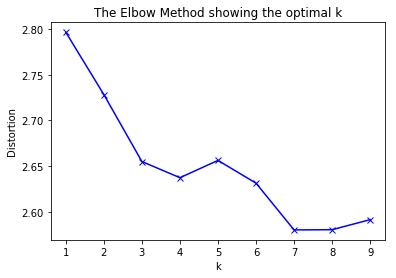

In [68]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X2)
    kmeanModel.fit(X2)
    distortions.append(sum(np.min(cdist(X2, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X2.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [69]:
X2_norm = normalize(X2)

# Calculate predicted values.
Y2_pred = KMeans(n_clusters=7, random_state=42).fit_predict(X2_norm)

In [70]:
bow_clusters_df = bow_df2.copy()

In [71]:
bow_clusters_df['clusters'] = Y2_pred

In [72]:
for i in range(bow_clusters_df['clusters'].nunique()):
    cluster = bow_clusters_df[bow_clusters_df['clusters']== i]
    print('Cluster ', i, '\n', Counter(list(cluster['authors'])),'\n')

Cluster  0 
 Counter({'Angelou': 21, 'Hughes': 19, 'Blake': 15, 'Frost': 14, 'Dickinson': 11, 'Yeats': 10, 'LiPo': 7, 'Rumi': 7, 'Neruda': 6, 'Shakespeare': 2}) 

Cluster  1 
 Counter({'Blake': 96, 'Angelou': 50, 'Frost': 34, 'Hughes': 31, 'Yeats': 29, 'Rumi': 20, 'Dickinson': 17, 'Neruda': 15, 'LiPo': 12, 'Shakespeare': 7}) 

Cluster  2 
 Counter({'Hughes': 104, 'Frost': 68, 'Dickinson': 56, 'Angelou': 45, 'Yeats': 40, 'Blake': 36, 'Rumi': 34, 'Shakespeare': 31, 'Neruda': 26, 'LiPo': 14}) 

Cluster  3 
 Counter({'Neruda': 9, 'Dickinson': 9, 'Shakespeare': 8, 'Frost': 7, 'Angelou': 7, 'Blake': 7, 'Rumi': 5, 'Yeats': 4, 'Hughes': 3, 'LiPo': 1}) 

Cluster  4 
 Counter({'Angelou': 41, 'Frost': 35, 'Neruda': 31, 'Hughes': 26, 'Yeats': 25, 'Rumi': 24, 'LiPo': 18, 'Blake': 15, 'Dickinson': 8, 'Shakespeare': 4}) 

Cluster  5 
 Counter({'Yeats': 47, 'Angelou': 24, 'Hughes': 16, 'Neruda': 6, 'LiPo': 2, 'Dickinson': 1}) 

Cluster  6 
 Counter({'Hughes': 67, 'Frost': 64, 'Angelou': 50, 'Neruda': 

In [73]:
df = bow_clusters_df[bow_clusters_df['clusters']== 0]

In [75]:
bandwidth = estimate_bandwidth(X2, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X2)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 17


In [76]:
bow_mean_shift_clusters = bow_df2.copy()

In [77]:
bow_mean_shift_clusters['clusters'] = labels

In [79]:
for i in range(bow_mean_shift_clusters['clusters'].nunique()):
    cluster = bow_mean_shift_clusters[bow_mean_shift_clusters['clusters']== i]
    print('Cluster ', i, '\n', Counter(list(cluster['authors'])),'\n')

Cluster  0 
 Counter({'Hughes': 259, 'Angelou': 227, 'Frost': 211, 'Blake': 173, 'Yeats': 157, 'Neruda': 135, 'Dickinson': 122, 'Rumi': 116, 'Shakespeare': 69, 'LiPo': 67}) 

Cluster  1 
 Counter({'Hughes': 2}) 

Cluster  2 
 Counter({'Frost': 1}) 

Cluster  3 
 Counter({'Angelou': 3, 'Yeats': 3, 'Hughes': 1}) 

Cluster  4 
 Counter({'Hughes': 1}) 

Cluster  5 
 Counter({'Rumi': 1}) 

Cluster  6 
 Counter({'Neruda': 1, 'Shakespeare': 1, 'Rumi': 1}) 

Cluster  7 
 Counter({'Neruda': 1}) 

Cluster  8 
 Counter({'Neruda': 1, 'LiPo': 1, 'Frost': 1, 'Yeats': 1}) 

Cluster  9 
 Counter({'Yeats': 1}) 

Cluster  10 
 Counter({'Angelou': 2, 'Frost': 1, 'Yeats': 1}) 

Cluster  11 
 Counter({'Shakespeare': 1, 'Hughes': 1}) 

Cluster  12 
 Counter({'Blake': 10, 'Frost': 8, 'Yeats': 5, 'Angelou': 4, 'Neruda': 2, 'Hughes': 1, 'Dickinson': 1, 'Rumi': 1}) 

Cluster  13 
 Counter({'Blake': 3, 'Angelou': 1}) 

Cluster  14 
 Counter({'Neruda': 1, 'Shakespeare': 1, 'Yeats': 1, 'Rumi': 1}) 

Cluster  15 
 